In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [13]:
import torch
from torchvision import transforms

In [14]:
def read_image(path):
    img = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    return img

In [36]:
input_size=224

transform_ori = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(input_size),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(10),
                        transforms.RandomAffine(degrees=0,translate=None,scale=None,shear=20),
                        # transforms.ToTensor(),
                        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

                    ])

transform_new = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(input_size),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(10),
                        transforms.RandomAffine(degrees=0,translate=None,scale=None,shear=20),
                        transforms.RandomEqualize(p=0.2)
                        # transforms.ToTensor(),
                        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

                    ])

In [37]:
path = "FaceMask/id_balanced/images/87324_2015_unmask.jpg"
path = "FaceMask/id_balanced/images/396402_1708_mask.jpg"

In [38]:
img = read_image(path)

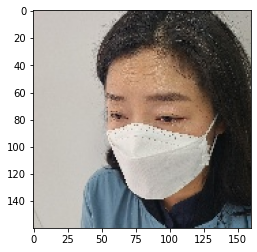

In [39]:
plt.imshow(img)

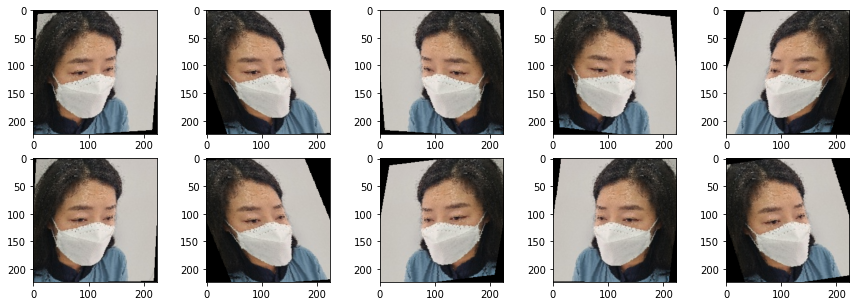

In [40]:
plt.figure(figsize=(15,5))
for i in range(10):
    trans_ori = transform_ori(img)
    plt.subplot(2,5,i+1)
    plt.imshow(trans_ori)

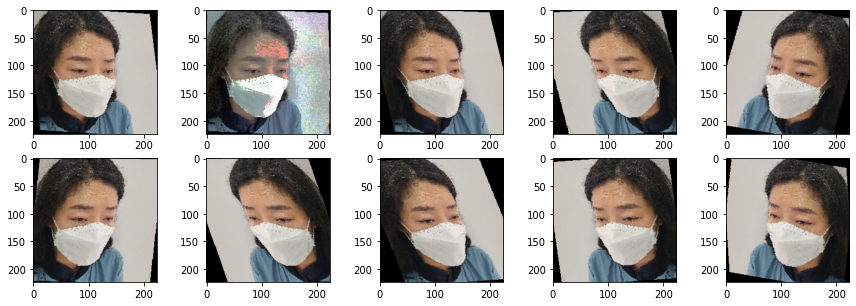

In [41]:
plt.figure(figsize=(15,5))
for i in range(10):
    trans_new = transform_new(img)
    plt.subplot(2,5,i+1)
    plt.imshow(trans_new)

In [42]:
def generate_FT(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fimg = np.log(np.abs(fshift)+1)
    maxx = -1
    minn = 100000
    for i in range(len(fimg)):
        if maxx < max(fimg[i]):
            maxx = max(fimg[i])
        if minn > min(fimg[i]):
            minn = min(fimg[i])
    fimg = (fimg - minn+1) / (maxx - minn+1)
    return fimg

In [43]:
fimg = generate_FT(img)

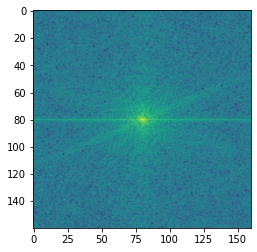

In [44]:
plt.imshow(fimg)

In [168]:
def generate_FT(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return fshift

In [175]:
# https://i-systems.github.io/teaching/image_proc/iNotes/02_image_in_freq_py.html#2.-Image-Filtering-in-Frequency
# 2.1. Low-Pass Filtering in Frequency
# Guassian type

def get_freq_filter(img):
    cm = img.copy()
    N = 160 #img size

    cmfr_list=[]
    for i in range(3):
        cm_i = cm[:,:,i]
        CMs = generate_FT(cm_i)

        x, y = np.meshgrid(np.arange(-int(N/2), int(N/2), 1), np.arange(-int(N/2), int(N/2), 1))
        Z = np.exp(- 0.0005*x**2 - 0.0005*y**2) # Gaussian

        CMFs = CMs*Z

        CMFr = np.fft.ifftshift(CMFs)
        cmfr = np.fft.ifft2(CMFr)
        cmfr_list.append(cmfr)

    cmfr_final = np.expand_dims(np.array(cmfr_list[0]),axis=-1)
    cmfr_final = np.concatenate((cmfr_final,np.expand_dims(cmfr_list[1],axis=-1)),axis=-1)
    cmfr_final = np.concatenate((cmfr_final,np.expand_dims(cmfr_list[2],axis=-1)),axis=-1)
    cmfr_final = cmfr_final.astype(np.uint8)
    
    return cmfr_final

In [176]:
cmfr = get_freq_filter(img)

/tmp/ipykernel_32576/2620050903.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  cmfr_final = cmfr_final.astype(np.uint8)


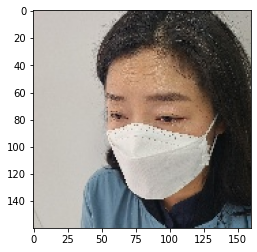

In [177]:
plt.imshow(img)

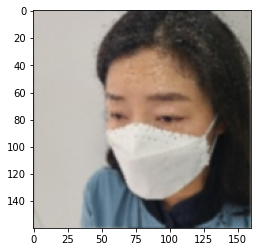

In [178]:
plt.imshow(cmfr)